In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
import os
os.chdir("/content/gdrive/My Drive/CS747_Assignment2")

Mounted at /content/gdrive


In [4]:
import torch
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


# Assignment 2 Part 1 Introduction: Multi-label Image Classification

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision

from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from kaggle_submission import output_submission_csv
from classifier import SimpleClassifier, Classifier#, AlexNet
from voc_dataloader import VocDataset, VOC_CLASSES

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Multi-label Classification
In this assignment, you train a classifier to do multi-label classificaton on the PASCAL VOC 2007 dataset. The dataset has 20 different class which can appear in any given image. Your classifier will predict whether each class appears in an image. This task is slightly different from exclusive multiclass classification like the ImageNet competition where only a single most appropriate class is predicted for an image.

## Part 1
You will use this notebook to warm up with pytorch and the code+dataset that we will use for assignment3. 

### What to do
In part 1, You are asked to run below experiments. You don't need to change hyperparameters for this Part 1's experiments. (the following code provides everything that you will need.)
1. to train a simple network (defined in ```classifiers.py```) 
2. to train the AlexNet (PyTorch built-in) 
    - from scratch 
    - finetuning AlexNet pretrained on ImageNet


    
### What to submit
We ask you to run the following code and report the results in your homework submission. You may want to leverage this part 1 get yourself familiar with PyTorch.

You will the need the numbers and plots this notebook outputs for reports, but you are not required to submit this notebook as a printed pdf. 

## Reading Pascal Data

### Loading Training Data

In the following cell we will load the training data and also apply some transforms to the data. 

In [6]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize
        ])


In [7]:
ds_train = VocDataset('VOCdevkit_2007/VOC2007/','train',train_transform)

/content/gdrive/My Drive/CS747_Assignment2/voc_dataloader.py:137: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(box_indices),


### Loading Validation Data

We will load the test data for the PASCAL VOC 2007 dataset. Do __NOT__ add data augmentation transforms to validation data.

In [8]:
# Transforms applied to the testing data
test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
        ])

In [14]:
ds_val = VocDataset('VOCdevkit_2007/VOC2007/','val',test_transform)

### Visualizing the Data

PASCAL VOC has bounding box annotations in addition to class labels. Use the following code to visualize some random examples and corresponding annotations from the train set. 

In [10]:
for i in range(5):
    idx = np.random.randint(0, len(ds_train.names)+1)
    _imgpath = os.path.join('VOCdevkit_2007/VOC2007/', 'JPEGImages', ds_train.names[idx]+'.jpg')
    img = Image.open(_imgpath).convert('RGB')
    draw = ImageDraw.Draw(img)
    for j in range(len(ds_train.box_indices[idx])):
        obj = ds_train.box_indices[idx][j]
        draw.rectangle(list(obj), outline=(255,0,0))
        draw.text(list(obj[0:2]), ds_train.classes[ds_train.label_order[idx][j]], fill=(0,255,0))
    plt.figure(figsize = (10,10))
    plt.imshow(np.array(img))

Output hidden; open in https://colab.research.google.com to view.

# Classification

In [11]:
# declare what device to use: gpu/cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=50, 
                                               shuffle=True,
                                               num_workers=1)

In [15]:
val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=50, 
                                               shuffle=True,
                                               num_workers=1)

In [16]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [17]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True, print_total=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,21))
        y_score = np.zeros((0,21))
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            aps.append(ap)
        
        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        if print_total:
            print('mAP: {0:.4f}'.format(mAP))
            print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

In [18]:
# plot functions
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_mAP(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("mAP Plot")
    plt.ylabel("mAP")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    

## Training the network 

The simple network you are given as is will allow you to reach around 0.15-0.2 mAP. In this project, you will find ways to design a better network. Save plots and final test mAP scores as you will be adding these to the writeup.

In [19]:
def train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency=5):
    train_losses = []
    train_mAPs = []
    val_losses = []
    val_mAPs = []

    for epoch in range(1,num_epochs+1):
        print("Starting epoch number " + str(epoch))
        train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
        train_losses.append(train_loss)
        print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
        if(epoch%test_frequency==0 or epoch==1):
            mAP_train, _, _ = test_classifier(train_loader, classifier, criterion, False, False)
            train_mAPs.append(mAP_train)
            mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
            print('Evaluating classifier')
            print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
            val_losses.append(val_loss)
            val_mAPs.append(mAP_val)
    
    return classifier, train_losses, val_losses, train_mAPs, val_mAPs

In [20]:
classifier = SimpleClassifier().to(device)
# You can can use this function to reload a network you have already saved previously
#classifier.load_state_dict(torch.load('voc_classifier.pth'))

In [21]:
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

In [22]:
# Training the Classifier
num_epochs = 20
test_frequency = 5

classifier, train_losses, val_losses, train_mAPs, val_mAPs = train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency)


Starting epoch number 1
Loss for Training on Epoch 1 is 0.47067973017692566
-------  Class: aeroplane        AP:   0.1003  -------
-------  Class: bicycle          AP:   0.0480  -------
-------  Class: bird             AP:   0.1176  -------
-------  Class: boat             AP:   0.0898  -------
-------  Class: bottle           AP:   0.0429  -------
-------  Class: bus              AP:   0.0290  -------
-------  Class: car              AP:   0.1116  -------
-------  Class: cat              AP:   0.0860  -------
-------  Class: chair            AP:   0.1211  -------
-------  Class: cow              AP:   0.0304  -------
-------  Class: diningtable      AP:   0.0531  -------
-------  Class: dog              AP:   0.1174  -------
-------  Class: horse            AP:   0.0512  -------
-------  Class: motorbike        AP:   0.0455  -------
-------  Class: person           AP:   0.3592  -------
-------  Class: pottedplant      AP:   0.0468  -------
-------  Class: sheep            AP:   0.027

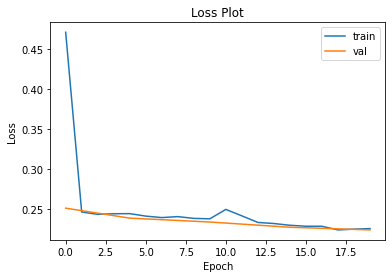

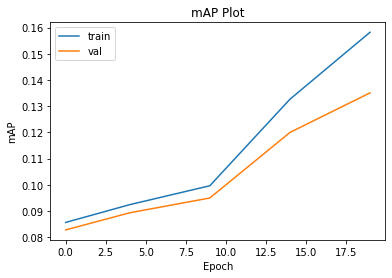

In [23]:
# Compare train and validation metrics
plot_losses(train_losses, val_losses, test_frequency, num_epochs)
plot_mAP(train_mAPs, val_mAPs, test_frequency, num_epochs)

In [24]:
# Save the clssifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
torch.save(classifier.state_dict(), './voc_simple_classifier.pth')

# Evaluate on test set



In [25]:
ds_test = VocDataset('VOCdevkit_2007/VOC2007test/','test', test_transform)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=50, 
                                               shuffle=False,
                                               num_workers=1)

# Transforms applied to the testing data
test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
        ])

mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

/content/gdrive/My Drive/CS747_Assignment2/voc_dataloader.py:137: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(box_indices),


-------  Class: aeroplane        AP:   0.2251  -------
-------  Class: bicycle          AP:   0.0605  -------
-------  Class: bird             AP:   0.1052  -------
-------  Class: boat             AP:   0.1557  -------
-------  Class: bottle           AP:   0.0701  -------
-------  Class: bus              AP:   0.0551  -------
-------  Class: car              AP:   0.2076  -------
-------  Class: cat              AP:   0.1233  -------
-------  Class: chair            AP:   0.1859  -------
-------  Class: cow              AP:   0.0590  -------
-------  Class: diningtable      AP:   0.0926  -------
-------  Class: dog              AP:   0.1525  -------
-------  Class: horse            AP:   0.0843  -------
-------  Class: motorbike        AP:   0.0480  -------
-------  Class: person           AP:   0.5144  -------
-------  Class: pottedplant      AP:   0.0553  -------
-------  Class: sheep            AP:   0.0703  -------
-------  Class: sofa             AP:   0.1467  -------
-------  C

In [26]:
output_submission_csv('my_solution.csv', test_aps)

# AlexNet Baselines (From Scratch)

AlexNet was one of the earliest deep learning models to have success in classification. In this section we will be running classification with AlexNet as a baseline. Furthermore, we will run an ImageNet-pretrained AlexNet to observe the impact of well-trained features. Save plots and final test mAP scores as you will be adding these to the writeup.

## Running AlexNet

In this section, we train AlexNet from scratch using the same hyperparameters as our previous experiment.

In [27]:
num_epochs = 20
test_frequency = 5

# Change classifier to AlexNet
classifier = torchvision.models.alexnet(pretrained=False)
classifier.classifier._modules['6'] = nn.Linear(4096, 21)   
classifier = classifier.to(device)

criterion = nn.MultiLabelSoftMarginLoss()

optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [28]:
classifier, train_losses, val_losses, train_mAPs, val_mAPs = train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency)

Starting epoch number 1
Loss for Training on Epoch 1 is 0.5893605947494507
-------  Class: aeroplane        AP:   0.1498  -------
-------  Class: bicycle          AP:   0.0438  -------
-------  Class: bird             AP:   0.1040  -------
-------  Class: boat             AP:   0.1357  -------
-------  Class: bottle           AP:   0.0370  -------
-------  Class: bus              AP:   0.0298  -------
-------  Class: car              AP:   0.1114  -------
-------  Class: cat              AP:   0.0981  -------
-------  Class: chair            AP:   0.1059  -------
-------  Class: cow              AP:   0.0359  -------
-------  Class: diningtable      AP:   0.0451  -------
-------  Class: dog              AP:   0.1122  -------
-------  Class: horse            AP:   0.0449  -------
-------  Class: motorbike        AP:   0.0343  -------
-------  Class: person           AP:   0.4848  -------
-------  Class: pottedplant      AP:   0.0403  -------
-------  Class: sheep            AP:   0.0361

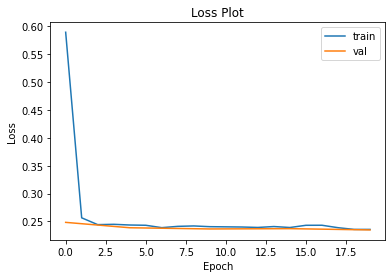

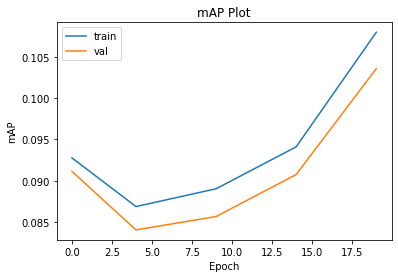

In [29]:
plot_losses(train_losses, val_losses, test_frequency, num_epochs)
plot_mAP(train_mAPs, val_mAPs, test_frequency, num_epochs)

In [30]:
mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)
print("Test mAP: ", mAP_test)

-------  Class: aeroplane        AP:   0.0915  -------
-------  Class: bicycle          AP:   0.0558  -------
-------  Class: bird             AP:   0.1008  -------
-------  Class: boat             AP:   0.0740  -------
-------  Class: bottle           AP:   0.0515  -------
-------  Class: bus              AP:   0.0340  -------
-------  Class: car              AP:   0.1646  -------
-------  Class: cat              AP:   0.0913  -------
-------  Class: chair            AP:   0.1387  -------
-------  Class: cow              AP:   0.0429  -------
-------  Class: diningtable      AP:   0.0581  -------
-------  Class: dog              AP:   0.1262  -------
-------  Class: horse            AP:   0.0544  -------
-------  Class: motorbike        AP:   0.0423  -------
-------  Class: person           AP:   0.5069  -------
-------  Class: pottedplant      AP:   0.0514  -------
-------  Class: sheep            AP:   0.0565  -------
-------  Class: sofa             AP:   0.1058  -------
-------  C

You should notice somewhat poor performance. You could try running AlexNet with an Adam optimizer instead with learning rate 1e-4 to see if that makes a difference. This experiment is not required for the writeup, but it may show you the importance of a good learning rate and optimizer.

## Pretrained AlexNet

Here we look at the impact of pretrained features. This model's weights were trained on ImageNet, which is a much larger dataset. How do pretrained features perform on VOC? Why do you think there is such a large difference in performance?

In [31]:
num_epochs = 20
test_frequency = 5

# Load Pretrained AlexNet
classifier = torchvision.models.alexnet(pretrained=True)
classifier.classifier._modules['6'] = nn.Linear(4096, 21)   
classifier = classifier.to(device)
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [32]:
classifier, train_losses, val_losses, train_mAPs, val_mAPs = train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency)

Starting epoch number 1
Loss for Training on Epoch 1 is 0.22288663685321808
-------  Class: aeroplane        AP:   0.7444  -------
-------  Class: bicycle          AP:   0.5541  -------
-------  Class: bird             AP:   0.8052  -------
-------  Class: boat             AP:   0.5640  -------
-------  Class: bottle           AP:   0.2239  -------
-------  Class: bus              AP:   0.5021  -------
-------  Class: car              AP:   0.7626  -------
-------  Class: cat              AP:   0.7138  -------
-------  Class: chair            AP:   0.5818  -------
-------  Class: cow              AP:   0.3062  -------
-------  Class: diningtable      AP:   0.4216  -------
-------  Class: dog              AP:   0.6422  -------
-------  Class: horse            AP:   0.6449  -------
-------  Class: motorbike        AP:   0.7065  -------
-------  Class: person           AP:   0.8986  -------
-------  Class: pottedplant      AP:   0.2935  -------
-------  Class: sheep            AP:   0.303

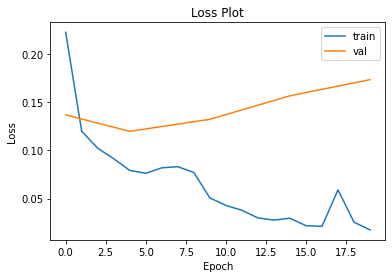

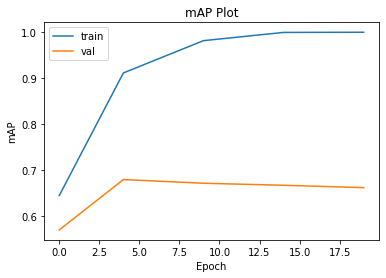

In [33]:
plot_losses(train_losses, val_losses, test_frequency, num_epochs)
plot_mAP(train_mAPs, val_mAPs, test_frequency, num_epochs)

In [34]:
mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)
print("Test mAP: ", mAP_test)

-------  Class: aeroplane        AP:   0.8671  -------
-------  Class: bicycle          AP:   0.7322  -------
-------  Class: bird             AP:   0.8068  -------
-------  Class: boat             AP:   0.7937  -------
-------  Class: bottle           AP:   0.3174  -------
-------  Class: bus              AP:   0.6342  -------
-------  Class: car              AP:   0.8349  -------
-------  Class: cat              AP:   0.7800  -------
-------  Class: chair            AP:   0.5506  -------
-------  Class: cow              AP:   0.5357  -------
-------  Class: diningtable      AP:   0.6016  -------
-------  Class: dog              AP:   0.7139  -------
-------  Class: horse            AP:   0.8462  -------
-------  Class: motorbike        AP:   0.7567  -------
-------  Class: person           AP:   0.9162  -------
-------  Class: pottedplant      AP:   0.3598  -------
-------  Class: sheep            AP:   0.6052  -------
-------  Class: sofa             AP:   0.5082  -------
-------  C